# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/NetML/Data/

/content/drive/MyDrive/NetML/Data


In [ ]:
!pip install -U googlemaps
!pip install ncls
!pip install cython

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
from datetime import datetime, timedelta
import googlemaps
import folium
from folium import plugins
import re
import requests
import json
import scipy
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from ncls import NCLS
import plotly.graph_objs as go
from scipy import stats
%load_ext cython


# Reading and Cleaning Data

In [ ]:
# Files created with GMAPS API for distance time to walk between each pair of buildings in the trace
dist = pd.read_csv('DistanceBetweenBuildings(meters).csv')
walkingTimes = pd.read_csv('WalkingTimeBetweenBuildings(seconds).csv')
# Contains building prefixes and building data
prefix_loc = pd.read_csv('prefix_lat_lon_name_category.csv')

In [ ]:
# Converting the data frame of the distances or durations into a 2D dictionary
def create_dist_or_dur_map(data):
    building_prefixes = [data.columns[i] for i in range(1, len(data.columns))]
    dist_map = { loc: {} for loc in building_prefixes}

    for index in range(len(building_prefixes)):
        distances = data.loc[index, :].values.flatten().tolist()[1:]
        loc_map = {}
        for dest in range(len(distances)):
            loc_map[building_prefixes[dest]] = distances[dest]
        dist_map[building_prefixes[index]] = loc_map
    
    return dist_map

In [ ]:
# Getting distance map
d_map = create_dist_or_dur_map(dist)

In [ ]:
# Getting walking duration map
dur_map = create_dist_or_dur_map(walkingTimes)

In [ ]:
def read_n_clean(file):
    df = pd.read_csv(file)
    # Adding a column for duration
    df['duration'] = df['endTime'] - df['startTime']
    # Dropping zero second sessions
    df = df.drop(df[df['duration'] == 0].index)
    # If there is a session started by the same user at the same time at the same place, the longest is kept
    df = df.sort_values(by=['startTime', 'duration'])
    df = df.drop_duplicates(subset =['APMAC','startTime', 'userMAC'], keep = 'last')
    return df

In [ ]:
# Getting the one week trace
apr1_df = read_n_clean('DHCP_April_2012_devType-day-1.csv')
apr2_df = read_n_clean('DHCP_April_2012_devType-day-2.csv')
apr3_df = read_n_clean('DHCP_April_2012_devType-day-3.csv')
apr4_df = read_n_clean('DHCP_April_2012_devType-day-4.csv')
apr5_df = read_n_clean('DHCP_April_2012_devType-day-5.csv')
apr6_df = read_n_clean('DHCP_April_2012_devType-day-6.csv')
apr7_df = read_n_clean('DHCP_April_2012_devType-day-7.csv')
apr8_df = read_n_clean('DHCP_April_2012_devType-day-8.csv')
apr9_df = read_n_clean('DHCP_April_2012_devType-day-9.csv')
apr10_df = read_n_clean('DHCP_April_2012_devType-day-10.csv')
apr11_df = read_n_clean('DHCP_April_2012_devType-day-11.csv')
apr12_df = read_n_clean('DHCP_April_2012_devType-day-12.csv')
apr13_df = read_n_clean('DHCP_April_2012_devType-day-13.csv')
apr14_df = read_n_clean('DHCP_April_2012_devType-day-14.csv')


apr1to7_df = pd.concat([apr1_df, apr2_df, apr3_df, apr4_df, apr5_df, apr6_df, apr7_df], axis=0)

In [ ]:
# Prefix function that separates letters and digits in APNAME and returns the letters for prefix match
def prefix(ap_name):
    x = ap_name.split("-")
    digit = False
    for c in x[0]:
        if c.isdigit():
            digit = True
            break
    if digit:
        pre = re.findall(r'(\w+?)(\d+)', x[0])[0][0]
    else:
        pre = x[0]
    return pre

In [ ]:
# Merge wlan traces with location data
def merge_location_WLAN(wlan_data, loc_data):
    # Applying prefix function to WLAN Dataframe to get building prefixes
    wlan_data['prefix'] = wlan_data.apply(lambda row: prefix(row.APNAME), axis = 1)

    # Prefix edgecases which have digits in prefixes as well
    num_pre = ["ff1", "ohl1", "ohl2", "rl1", "rl2"]
    for i in num_pre:
        wlan_data.loc[wlan_data["APNAME"].str.startswith(i), "prefix"] = i

    # Inner join on df and prefix df
    merged_df = pd.merge(wlan_data, loc_data, on='prefix', how='left')

    # Dropping all rows that have null values due to not being matched with a prefix
    merged_df.dropna(inplace=True)

    # Sorting by time
    merged_df = merged_df.sort_values(by=['startTime', 'duration'])

    return merged_df

In [ ]:
# groups merged dataframe by users
def create_user_groups(df, prefix_map):
    merged_df = merge_location_WLAN(df, prefix_map)
    merged_df = merged_df.sort_values(by=['startTime', 'duration'])
    users = merged_df.groupby('userMAC')

    return users

In [ ]:
ap1_users = create_user_groups(apr1_df, prefix_loc)
ap2_users = create_user_groups(apr2_df, prefix_loc)
ap3_users = create_user_groups(apr3_df, prefix_loc)
ap4_users = create_user_groups(apr4_df, prefix_loc)
ap5_users = create_user_groups(apr5_df, prefix_loc)
ap6_users = create_user_groups(apr6_df, prefix_loc)
ap7_users = create_user_groups(apr7_df, prefix_loc)
ap8_users = create_user_groups(apr8_df, prefix_loc)
ap9_users = create_user_groups(apr9_df, prefix_loc)
ap10_users = create_user_groups(apr10_df, prefix_loc)
ap11_users = create_user_groups(apr11_df, prefix_loc)
ap12_users = create_user_groups(apr12_df, prefix_loc)
ap13_users = create_user_groups(apr13_df, prefix_loc)
ap14_users = create_user_groups(apr14_df, prefix_loc)

In [ ]:
apr1to7_df_merged = merge_location_WLAN(apr1to7_df, prefix_loc)

# On-Campus Students

In [ ]:
# residential students
def find_residential(merged_df):
  merged_df = merged_df[merged_df['category'] == 'housing']
  return merged_df

onCampusStudents = find_residential(apr1to7_df_merged)

In [ ]:
# late night students
def late_night_students(file):
  df = file
  clean_df1 = df.copy()
  clean_df2 = df.copy()
  clean_df2 = clean_df2[clean_df2['category'] == 'housing']
  # print("Clean_df2.unique: ", clean_df2.nunique())
  # need to get the current day
  day = (clean_df1.iloc[0].startTimeF)[0:10]
  morning_threshold = day + " 06:00:00"
  night_threshold = day + " 22:00:0"
  # drop all students on campus (6am < students < 10pm)
  clean_df1 = clean_df1.drop(clean_df1[((clean_df1.startTimeF > morning_threshold) & (clean_df1.startTimeF < night_threshold))].index)
  # print("Daytime Records Removed: " + str(df['userMAC'].count() - clean_df1['userMAC'].count()))
  clean_df1.append(clean_df2)
  return clean_df1

lateNightStudents = late_night_students(apr1to7_df_merged)

In [ ]:
# merge the two data frames to get total On-Campus Students
studentsMerged = onCampusStudents.append(lateNightStudents)

# Resume Data Cleaning

In [ ]:
# Maps a user MAC to its device type
# Needed since the device type and user MAC cannot be passed to the NCLS function
def mapUserMacToDeviceType(data):
    userToDevice = {}
    data = data[['userMAC', 'deviceType']]
    data = data.drop_duplicates()
    data["deviceType"] = np.where(data["deviceType"] == "f", 1, 0)
    for row in data.iterrows():
      userToDevice[row[1]['userMAC']] = row[1]['deviceType']
    return userToDevice

In [ ]:
def get_f_c_overlap_encounter_map(data, duration, userToDevice):
    # Clean the data of events that are less than the given duration. 
    data = data[data['duration'] >= duration]
    # Changing f to 1 and c to 0 for speed up
    data["deviceType"] = np.where(data["deviceType"] == "f", 1, 0)
    # Getting rid of unnecessary columns and grouping data by APMAC and startTime to get encountered devices
    data = data[['APMAC', 'userMAC', 'startTime', 'endTime', 'deviceType']]
    groups = data.groupby(['APMAC'])
    # Create a dict obj to store encounter adjacency list for each user consisting of total frequency and encounter duration
    encounter_map = {}
    for ap_name, ap_df in groups:
        # Creating NCLS object for all sessions at the AP with user MAC as id
        ncls = NCLS(ap_df['startTime'], ap_df['endTime'], ap_df['userMAC'])
        # Going through each session and finding its associated encounters
        for i in range(len(ap_df)):
            user = ap_df.iloc[i]['userMAC']
            user_device_type = ap_df.iloc[i]['deviceType']
            start = ap_df.iloc[i]['startTime']
            end = ap_df.iloc[i]['endTime']
            # Initialzing the user's entry
            if user not in encounter_map.keys():
                encounter_map[user] = {}
            # Getting encounters
            it = ncls.find_overlap(start, end)
            for j in it:
                encounter_start = max(start, j[0])
                encounter_end = min(end, j[1])
                duration = encounter_end - encounter_start
                # Getting device type with mapping of user MACs to device types
                partner_device_type = userToDevice[j[2]]
                if (user_device_type != partner_device_type):
                    # Adding the frequency and duration to the running total
                    freqNDur = encounter_map[user].get(j[2], [0, 0])
                    freqNDur[0] = freqNDur[0] + 1
                    freqNDur[1] = freqNDur[1] + duration
                    encounter_map[user][j[2]] = freqNDur
    return encounter_map

In [ ]:
# Uses the encounter map to group devices together to one user MAC if they
# are each other's "best friend"
def groupDevices(encounter_map):
    bestFriends = {}
    for user in list(encounter_map):
        if user in encounter_map:
            encounteredUsers = encounter_map[user]
            freqs = np.array([])
            durations = np.array([])
            # Maintains order of user MACs for identification
            usersInOrder = np.array([])
            if encounteredUsers:
                # Gets array of encounter frequencies and durations and standardizes both
                for encounteredUser in encounteredUsers:
                    freqs = np.append(freqs, encounteredUsers[encounteredUser][0])
                    durations = np.append(durations, encounteredUsers[encounteredUser][1])
                    usersInOrder = np.append(usersInOrder, encounteredUser)
                freqs = freqs - np.mean(freqs)
                if np.std(freqs) != 0:
                    freqs = freqs / np.std(freqs)
                durations = durations - np.mean(durations)
                if np.std(durations) != 0:
                    durations = durations / np.std(durations)
                # Adds the standardized frequency and duration together to get score
                score = freqs + durations
                # User MAC with the highest score is best friend
                bestFriends[user] = usersInOrder[np.argmax(score)]
                # Space management
                del encounter_map[user]
    # If two devices are each other best friends, on the user MACs gets mapped to the other
    newUserMacs = {}
    for user in list(bestFriends):
        if user in bestFriends:
            bestFriend = bestFriends[user]
            if bestFriend in bestFriends:
                if user == bestFriends[bestFriend]:
                    newUserMacs[user] = bestFriend
                    del bestFriends[bestFriend]
    # Dictionary of new assignments for user MACs
    return newUserMacs

In [ ]:
# Lambda function for assignment of new user MAC
def mapMAC(mac, newUserMacs):
    if mac in newUserMacs:
        return newUserMacs[mac]
    else:
        return mac

In [ ]:
def multipleDevicesOneUser(data):
    print('Devices in trace:', data['userMAC'].nunique())
    userToDevice = mapUserMacToDeviceType(data)
    encounter_map = get_f_c_overlap_encounter_map(data, 0, userToDevice)
    newUserMacs = groupDevices(encounter_map)
    print('Devices paired:', 2 * len(newUserMacs))
    data['userMAC'] = data['userMAC'].apply(lambda mac: mapMAC(mac, newUserMacs))
    return data

In [ ]:
apr1to7_df_merged = multipleDevicesOneUser(apr1to7_df_merged)

Devices in trace: 58402
Devices paired: 5526


In [ ]:
# Groups users using groupby
def get_users(merged_df):
    users = merged_df.groupby('userMAC')
    return users

In [ ]:
apr1to7_users = get_users(apr1to7_df_merged)

In [ ]:
# get all unique users for all On-Campus Students
OnCampus_Users = get_users(studentsMerged)

# Creating Distance and Duration Between Building Files From Google Maps API

In [ ]:
# Use GMAPS API to save a csv of distance and time to walk between all pairs of buildings in trace
def getDistAndDurBetwBuild(prefix_loc):
    # For GMAPS API request
    url1 = "https://maps.googleapis.com/maps/api/distancematrix/json?origins="
    url2 = "&destinations="
    url3 = "&mode=walking&key="
    # API key
    key = ""
    # Initializing matrices for distance and walking duration between buildings
    A = np.zeros([188, 188])
    B = np.zeros([188, 188])

    # Irrelevant, needed as parameters for API request
    headers = {}
    payload = {}

    # Getting list of prefix name
    prefixes = prefix_loc['prefix'].tolist()
    # Iterate through each pair of buildings
    for i, row in prefix_loc.iterrows():
        for j in range(i+1, 188):
            # Getting lat and lon for both buildings for API call
            originLat = str(row['lat'])
            originLon = str(row['lon'])
            destLat = str(prefix_loc.iloc[j]['lat'])
            destLon = str(prefix_loc.iloc[j]['lon'])
            if originLat == destLat and originLon == destLon: continue
            url = url1 + originLat + "%2C" + originLon + url2 + destLat + "%2C" + destLon + url3 + key
            response = requests.request("GET", url, headers=headers, data=payload)
            data = response.json()
            # Handling faulty requests
            while (data['destination_addresses'] == []):
                response = requests.request("GET", url, headers=headers, data=payload)
                data = response.json()
            # Getting walking time and distance from the response
            walkingTime = data['rows'][0]['elements'][0]['duration']['value']
            walkingDist = data['rows'][0]['elements'][0]['distance']['value']
            A[i, j] = walkingTime
            A[j, i] = walkingTime
            B[i, j] = walkingDist
            B[j, i] = walkingDist
    # Converting matrices to dataframes and saving as a csv
    dfA = pd.DataFrame(A, columns = prefixes)
    dfB = pd.DataFrame(B, columns = prefixes)
    dfA.to_csv("WalkingTimeBetweenBuildings(seconds).csv")
    dfB.to_csv("DistanceBetweenBuildings(meters).csv")

In [ ]:
getDistAndDurBetwBuild(prefix_loc)

# Distance Map Creation

In [ ]:
# Calculates distance travelled each day for every user
def calculate_user_dist_map(user_group, loc_distance_map):
    user_distance_map = {}

    for user, user_df in user_group:
        if len(user_df) <= 1:
            user_distance_map[user] = 0
            continue

        distance = 0    
        for index in range(1, len(user_df)):
            start = user_df.iloc[index-1, 11]
            end = user_df.iloc[index, 11]

            if end == start:
                continue
            
            distance += loc_distance_map[start][end]

        user_distance_map[user] = distance

    return user_distance_map

In [ ]:
# calculates avergage distance per day
def calculate_avg_dist(user_distance_map):
    total_distance = 0
    num_users = 0

    for key, val in user_distance_map.items():
        total_distance += val
        num_users += 1

    avg_dist = total_distance / num_users

    return total_distance, num_users, avg_dist

In [ ]:
# helper func to get results for graph for each day
def get_results_dist(users, distance_map):
    user_distance_map = calculate_user_dist_map(users, distance_map)
    total_dist, num_users, avg_dist = calculate_avg_dist(user_distance_map)

    return (total_dist, num_users, avg_dist)

In [ ]:
ap1_total_dist, ap1_num_users, ap1_avg_dist = get_results_dist(ap1_users, d_map)
ap2_total_dist, ap2_num_users, ap2_avg_dist = get_results_dist(ap2_users, d_map)
ap3_total_dist, ap3_num_users, ap3_avg_dist = get_results_dist(ap3_users, d_map)
ap4_total_dist, ap4_num_users, ap4_avg_dist = get_results_dist(ap4_users, d_map)
ap5_total_dist, ap5_num_users, ap5_avg_dist = get_results_dist(ap5_users, d_map)
ap6_total_dist, ap6_num_users, ap6_avg_dist = get_results_dist(ap6_users, d_map)
ap7_total_dist, ap7_num_users, ap7_avg_dist = get_results_dist(ap7_users, d_map)
ap8_total_dist, ap8_num_users, ap8_avg_dist = get_results_dist(ap8_users, d_map)
ap9_total_dist, ap9_num_users, ap9_avg_dist = get_results_dist(ap9_users, d_map)
ap10_total_dist, ap10_num_users, ap10_avg_dist = get_results_dist(ap10_users, d_map)
ap11_total_dist, ap11_num_users, ap11_avg_dist = get_results_dist(ap11_users, d_map)
ap12_total_dist, ap12_num_users, ap12_avg_dist = get_results_dist(ap12_users, d_map)
ap13_total_dist, ap13_num_users, ap13_avg_dist = get_results_dist(ap13_users, d_map)
ap14_total_dist, ap14_num_users, ap14_avg_dist = get_results_dist(ap14_users, d_map)



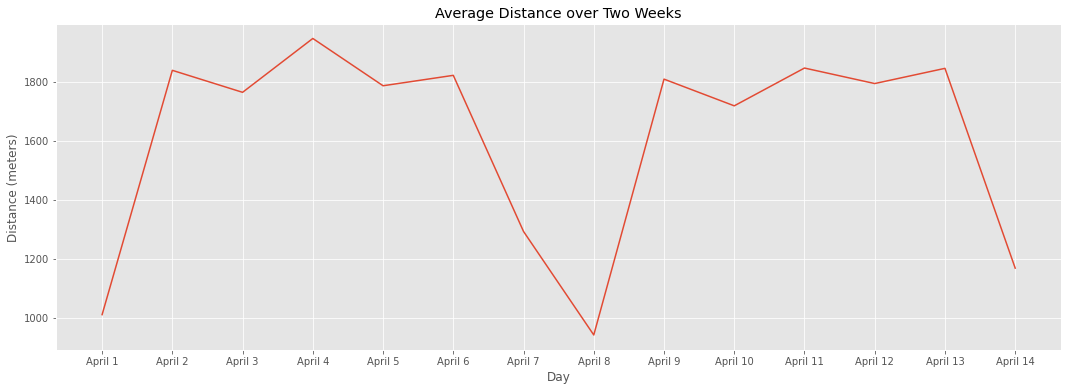

In [ ]:
x = ['April 1', 'April 2', 'April 3', 'April 4', 'April 5', 'April 6', 'April 7', 'April 8', 'April 9', 'April 10', 'April 11', 'April 12', 'April 13', 'April 14']
y = [ap1_avg_dist, ap2_avg_dist, ap3_avg_dist, ap4_avg_dist, ap5_avg_dist, ap6_avg_dist, ap7_avg_dist, ap8_avg_dist, 
     ap9_avg_dist, ap10_avg_dist, ap11_avg_dist, ap12_avg_dist, ap13_avg_dist, ap14_avg_dist]

plt.figure(figsize=(18,6))
plt.style.use("ggplot")

plt.plot(x, y)

plt.title('Average Distance over Two Weeks')
plt.xlabel('Day')
plt.ylabel('Distance (meters)')

plt.show()

In [ ]:
user_distance_map = calculate_user_dist_map(users, d_map)

In [ ]:
user_distance_map[31105]

52162.0

In [ ]:
apr1to7_total_dist, apr1to7_num_users, apr1to7_avg_dist = calculate_avg_dist(user_distance_map)

In [ ]:
print(apr1to7_avg_dist)

4777.786291565358


# Walking Time

In [ ]:
# combines expected time data with WLAN traces data
def create_walk_map(data):
    building_prefixes = [data.columns[i] for i in range(1, len(data.columns))]
    walk_map = { loc: {} for loc in building_prefixes}

    for index in range(len(building_prefixes)):
        walk_time = data.loc[index, :].values.flatten().tolist()[1:]
        loc_map = {}
        for dest in range(len(walk_time )):
            loc_map[building_prefixes[dest]] = walk_time[dest]
        walk_map[building_prefixes[index]] = loc_map
    
    return walk_map

w_map = create_walk_map(walkingTimes)

In [ ]:
# calculates walking time for each user
def calculate_user_walk_map(user_group, loc_walk_map):
    user_walk_map = {}

    for user, user_df in user_group:
        if len(user_df) <= 1:
            user_walk_map[user] = 0
            continue

        time = 0    
        for index in range(1, len(user_df)):
            start = user_df.iloc[index-1, 11]
            end = user_df.iloc[index, 11]

            if end == start:
                # print(f"{start} - {dest} = 0")
                continue
            
            time += loc_walk_map[start][end]
            # print(f"{start} - {dest} = {d_map[start][dest]}")

        user_walk_map[user] = time

    return user_walk_map

In [ ]:
# calculates average walking time per day
def calculate_avg_time(user_walk_map):
    total_time = 0
    num_users = 0

    for key, val in user_walk_map.items():
        total_time += val
        num_users += 1

    avg_time = total_time / num_users

    return total_time, num_users, avg_time

In [ ]:
# helper func to return results for graph
def get_results(users, walk_map):
    user_walk_map = calculate_user_walk_map(users, walk_map)
    total_time, num_users, avg_time = calculate_avg_time(user_walk_map)

    return (total_time, num_users, avg_time)

In [ ]:
ap1_total_time, ap1_num_users, ap1_avg_time = get_results(ap1_users, w_map)
ap2_total_time, ap2_num_users, ap2_avg_time = get_results(ap2_users, w_map)
ap3_total_time, ap3_num_users, ap3_avg_time = get_results(ap3_users, w_map)
ap4_total_time, ap4_num_users, ap4_avg_time = get_results(ap4_users, w_map)
ap5_total_time, ap5_num_users, ap5_avg_time = get_results(ap5_users, w_map)
ap6_total_time, ap6_num_users, ap6_avg_time = get_results(ap6_users, w_map)
ap7_total_time, ap7_num_users, ap7_avg_time = get_results(ap7_users, w_map)
ap8_total_time, ap8_num_users, ap8_avg_time = get_results(ap8_users, w_map)
ap9_total_time, ap9_num_users, ap9_avg_time = get_results(ap9_users, w_map)
ap10_total_time, ap10_num_users, ap10_avg_time = get_results(ap10_users, w_map)
ap11_total_time, ap11_num_users, ap11_avg_time = get_results(ap11_users, w_map)
ap12_total_time, ap12_num_users, ap12_avg_time = get_results(ap12_users, w_map)
ap13_total_time, ap13_num_users, ap13_avg_time = get_results(ap13_users, w_map)
ap14_total_time, ap14_num_users, ap14_avg_time = get_results(ap14_users, w_map)


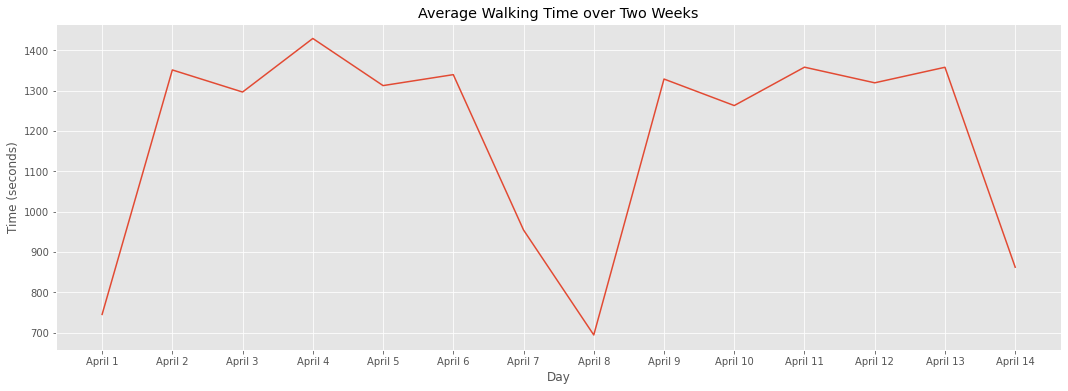

In [ ]:
x = ['April 1', 'April 2', 'April 3', 'April 4', 'April 5', 'April 6', 'April 7', 'April 8', 'April 9', 'April 10', 'April 11', 'April 12', 'April 13', 'April 14']
y = [ap1_avg_time, ap2_avg_time, ap3_avg_time, ap4_avg_time, ap5_avg_time, ap6_avg_time, ap7_avg_time, ap8_avg_time, 
     ap9_avg_time, ap10_avg_time, ap11_avg_time, ap12_avg_time, ap13_avg_time, ap14_avg_time]

plt.figure(figsize=(18,6))
plt.style.use("ggplot")

plt.plot(x, y)

plt.title('Average Walking Time over Two Weeks')
plt.xlabel('Day')
plt.ylabel('Time (seconds)')

plt.show()

# Stationary Time

In [ ]:
# calculates stationary time for each user: threshold is duration in mins required
def calculate_stationary_time(user_group, threshold):
    user_sit_map = {}

    for user, user_df in user_group:
        sit_time = 0    
        for index in range(0, len(user_df)):
            category = user_df.iloc[index, 15]
            if category in ('academic', 'housing', 'social', 'library'):
                duration = user_df.iloc[index, 10]
                if duration >= threshold:
                    sit_time += duration

        user_sit_map[user] = sit_time

    return user_sit_map

In [ ]:
threshold_duration = 600 # 10 mins
ap1_user_sit_map = calculate_stationary_time(ap1_users, threshold_duration)

In [ ]:
ap1_user_sit_map[38140]

18611

# Gathering Time of Movement Distribution

In [ ]:
# Needed to normalize duration of time walking based on end time
# and stationary time based on start time
def getTimeOMovementDist(data):
    df = data.copy()
    # Modding time by amount of seconds in a day
    df['endTime'] = df['endTime'] % 86400
    df['startTime'] = df['startTime'] % 86400
    # Graphing distribution of start and end times, binned by hour
    plt.hist(df['endTime'], bins=24)
    ticks = np.array(range(9)) * 10800
    labels = []
    for i in range(9):
        labels.append(str(3 * i) + ':00')
    plt.xticks(ticks, labels)
    plt.xlabel('Hour of Day')
    plt.ylabel('End Time Count')
    plt.title('Session End Times at Hours of the Day')
    plt.show()
    plt.hist(df['startTime'], bins=24)
    plt.xticks(ticks, labels)
    plt.xlabel('Hour of Day')
    plt.ylabel('Start Time Count')
    plt.title('Session Start Times at Hours of the Day')
    plt.show()
    # Getting percent of total for the hourly bins for start and end time
    bins = np.array(range(25)) * 3600
    countsWalk = df['endTime'].value_counts(bins=bins).sort_index()
    countsWalk = countsWalk / countsWalk.sum()
    countsStation = df['startTime'].value_counts(bins=bins).sort_index()
    countsStation = countsStation / countsStation.sum()
    # Returning percent of total movement in one hour bin
    return (countsWalk, countsStation)

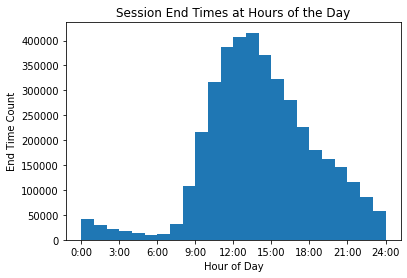

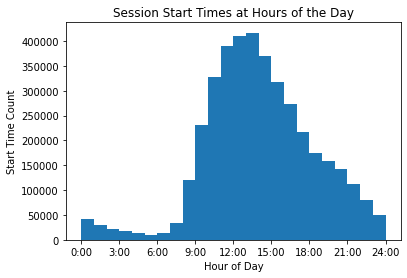

In [ ]:
# change to studentsMerged to get countsWalk/countsStation for On-Campus Students
countsWalk, countsStation = getTimeOMovementDist(apr1to7_df_merged)

# Getting Feature Matrix

In [ ]:
def getFeatureMatrix(users, countsStation, countsWalk):
  # Going to store all health features for each userMAC
  healthFeatures = {}
  # The 'active' buildings
  actiBuild = ["crec", "crecxxxrxx", "flg", "rfc", "swc"]
  print(len(users))
  for i, group in enumerate(users):
      if i % 1000 == 0:
        print(i)
      userSessions = group[1]
      userMac = group[0]
      # Store time spent at active locations (index 0), frequency of active location sessions (index 1),
      # normalized time spent walking (index 2), and normalized stationary time (index 3)
      healthFeatures[userMac] = [0, 0, 0, 0, userMac]
      # Modding by seconds in a day to see what bin it is in
      userSessions['startTime'] = userSessions['startTime'] % 86400
      userSessions['endTime'] = userSessions['endTime'] % 86400
      # Keeping track of days so normalization occurs day to day
      statDay = None
      walkDay = None
      # Will keep track of what hours (bins) the walking is captured for normalization
      walkNormalizationBins = set([])
      # Will keep track of what hours (bins) the stationary time is captured for normalization
      statNormalizationBins = set([])
      # Not normalized times
      walkUnNormal = 0
      statUnNormal = 0
      # Iterating through all of user's sessions
      for j in range(0, len(userSessions)):
          # Frequency and duration at active buildings
          # Checking if building is an active building and adding duration of time spent there if it is
          pre = userSessions.iloc[j]['prefix']
          if any(pre in s for s in actiBuild):
              healthFeatures[userMac][0] = healthFeatures[userMac][0] + userSessions.iloc[j]['duration']
              healthFeatures[userMac][1] = healthFeatures[userMac][1] + 1
          # Stationary time
          # Checking if building is a stationary building
          category = userSessions.iloc[j]['category']
          if category in ('academic', 'housing', 'social', 'library'):
              statDuration = userSessions.iloc[j]['duration']
              # Adding duration of time spent there greater than ten minutes
              if statDuration >= 600:
                  # Normalizing for each day
                  if userSessions.iloc[j]['day'] != statDay and statDay != None:
                      statNormVal = 0.0
                      for bin in statNormalizationBins:
                          statNormVal = statNormVal + countsStation[bin]
                      if statUnNormal != 0:
                          healthFeatures[userMac][3] = statUnNormal / statNormVal
                      statUnNormal = 0
                      statNormalizationBins = set([])
                  # Floor division by seconds in an hour to get the bin
                  statBin = userSessions.iloc[j]['startTime'] // 3600
                  # Add bin to set
                  statNormalizationBins.add(statBin)
                  # Add to not normalized total
                  statUnNormal = statUnNormal + statDuration
                  statDay = userSessions.iloc[j]['day']
          # Duration of time walking
          # Can't be done at last session since uses the successor session
          if j != len(userSessions) - 1:
              # Gets the building prefixes and gets duration to walk between
              origBuil = str(userSessions.iloc[j]['prefix'])
              destBuil = str(userSessions.iloc[j+1]['prefix'])
              walkDuration = dur_map[origBuil][destBuil]
              # If same building continue
              if userSessions.iloc[j]['day'] == userSessions.iloc[j+1]['day'] and walkDuration != 0:
                if userSessions.iloc[j]['day'] != walkDay and walkDay != None:
                      walkNormVal = 0.0
                      for bin in walkNormalizationBins:
                          walkNormVal = walkNormVal + countsWalk[bin]
                      if walkUnNormal != 0:
                          healthFeatures[userMac][2] = walkUnNormal / walkNormVal
                      walkUnNormal = 0
                      walkNormalizationBins = set([])
                # Floor division by seconds in an hour to get the bin
                walkBin = userSessions.iloc[j]['endTime'] // 3600
                # Add bin to set
                walkNormalizationBins.add(walkBin)
                # Add to not normalized total
                walkUnNormal = walkUnNormal + walkDuration
                walkDay = userSessions.iloc[j]['day']
      # Normalizing based off distribution in previous function
      walkNormVal = 0.0
      for bin in walkNormalizationBins:
          walkNormVal = walkNormVal + countsWalk[bin]
      if walkUnNormal != 0:
          healthFeatures[userMac][2] = walkUnNormal / walkNormVal
      statNormVal = 0.0
      for bin in statNormalizationBins:
          statNormVal = statNormVal + countsStation[bin]
      if statUnNormal != 0:
          healthFeatures[userMac][3] = statUnNormal / statNormVal
  # Putting all features in a matrix and returning it
  featureMatrix = np.array(list(healthFeatures.items()))
  featureMatrix = np.vstack(featureMatrix[:,1])

  return featureMatrix

In [ ]:
# change apr1to7_users to OnCampus_Users to get featureMatrix for On-Campus Students
featureMatrix = getFeatureMatrix(apr1to7_users, countsStation, countsWalk)

55639
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
saveFeatures = pd.DataFrame(featureMatrix, columns = ['Acti Loc Time', 'Acti Loc Freq', 'Walk Time', 'Stationary Time', 'userMAC'])
saveFeatures.to_csv("FeatureMatrixWitUserMAC.csv")

In [ ]:
featureMatrixWitUserMAC = pd.read_csv("FeatureMatrixWitUserMAC.csv") # reading saved featureMatrix

In [ ]:
inOrderMACs = featureMatrixWitUserMAC['userMAC']
featureMatrix = featureMatrixWitUserMAC[['Acti Loc Time', 'Acti Loc Freq', 'Walk Time', 'Stationary Time']] # naming features
featureMatrix = featureMatrix.loc[(featureMatrix != 0).any(axis=1)] # removing all zero rows
featureMatrix = featureMatrix.drop(featureMatrix[featureMatrix['Acti Loc Time'] >= 80000].index) # removing outliers
inOrderMACs = inOrderMACs.loc[featureMatrix.index]
featureMatrixWitUserMAC = featureMatrixWitUserMAC.loc[featureMatrix.index]

In [ ]:
onCampMACs = onCampusStudents['userMAC'].unique()
onCampMACs = pd.DataFrame(onCampMACs, columns = ['userMAC'])
onCampFeatMatrWitUserMac = pd.merge(featureMatrixWitUserMAC, onCampMACs, on='userMAC', how='inner')
onCampMACs = onCampFeatMatrWitUserMac['userMAC']
onCampFeatMatr = onCampFeatMatrWitUserMac[['Acti Loc Time', 'Acti Loc Freq', 'Walk Time', 'Stationary Time']]

In [ ]:
def getClusters(featureMatrix, inOrderMACs):
    standarFeatureMatrix = (featureMatrix-featureMatrix.mean()) / featureMatrix.std()
    pca = PCA(3)
    X = pca.fit_transform(standarFeatureMatrix)
    kmeans = KMeans(init='random', n_clusters=3, random_state=0).fit(X)
    labels = kmeans.labels_
    X_NEW = np.vstack([X[:,0], X[:,1], X[:,2], labels, inOrderMACs])
    X_NEW = X_NEW.T

    topClust = stats.mode(X_NEW[:,3])[0][0]
    X_NEW[:,3] = np.where(X_NEW[:,3] == topClust, 0.0, 2.0)
    X_BigClust = X_NEW[X_NEW[:,3] == 0.0]
    X_MOST_ACTIVE = X_NEW[X_NEW[:,3] == 2.0]

    kmeans2 = KMeans(init='random', n_clusters=2, random_state=0).fit(X_BigClust[:,0:3])
    labels2 = kmeans2.labels_
    X_NEW_MIDDLE_N_LEAST = np.vstack([X_BigClust[:,0], X_BigClust[:,1], X_BigClust[:,2], labels2, X_BigClust[:,4]])
    X_NEW_MIDDLE_N_LEAST = X_NEW_MIDDLE_N_LEAST.T
    topClust = stats.mode(X_NEW_MIDDLE_N_LEAST[:,3])[0][0]
    X_NEW_MIDDLE_N_LEAST[:,3] = np.where(X_NEW_MIDDLE_N_LEAST[:,3] == topClust, 0.0, 1.0)

    X_NEW = np.concatenate((X_MOST_ACTIVE, X_NEW_MIDDLE_N_LEAST))

    fig = go.Figure(data=[go.Scatter3d(x=X_NEW[:,0], y=X_NEW[:,1], z=X_NEW[:,2], mode='markers', marker=dict(size=1,\
        color=X_NEW[:,3], colorscale='Viridis', opacity=0.8, showscale=True))])
    fig.update_layout(autosize=True, margin=dict(l=10, r=10, b=50, t=50))
    fig.show()

    clus = X_NEW[:,3].astype('int')
    clusterCount = np.bincount(clus)
    counts = clusterCount.reshape(1,3)
    cols = ['No Activity', 'Low Activity','Recommended Activity']
    # Creating a datagrame
    countscldf = pd.DataFrame(counts, columns = cols)

    return X_NEW

In [ ]:
def showBinCounts(X_NEW):
    clus = X_NEW[:,3].astype('int')
    clusterCount = np.bincount(clus)
    counts = clusterCount.reshape(1,3)
    cols = ['No Activity', 'Low Activity','Recommended Activity']
    # Creating a datagrame
    countscldf = pd.DataFrame(counts, columns = cols)

    plt.bar(range(len(clusterCount)), clusterCount)
    plt.xticks(range(len(clusterCount)), cols)
    plt.xlabel('Activity Level')
    plt.ylabel('No. of Users')
    plt.title('KMeans-Clustering')
    plt.show()

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'No Activity', 'Low Activity','Recommended Activity'
    sizes = [(i/clusterCount.sum())*100 for i in clusterCount]
    explode = (0, 0, 0)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=50)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
def silhouette(featureMatrix):
    standarFeatureMatrix = (featureMatrix-featureMatrix.mean()) / featureMatrix.std()
    pca = PCA(3)
    X = pca.fit_transform(standarFeatureMatrix)
    # Calculate Silhoutte Score
    kmeans = KMeans(init='random', n_clusters=3, random_state=0).fit(X)
    score = silhouette_score(X, kmeans.labels_, metric='euclidean')

    # Print the score
    print('Silhouetter Score: %.3f' % score)

    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in [2, 3, 4, 5]:
        '''
        Create KMeans instance for different number of clusters
        '''
        km = KMeans(n_clusters=i, init='random', random_state=0)
        q, mod = divmod(i, 2)
        '''
        Create SilhouetteVisualizer instance with KMeans instance
        Fit the visualizer
        '''
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(X)

In [ ]:
featMatrWitClust = getClusters(featureMatrix, inOrderMACs)

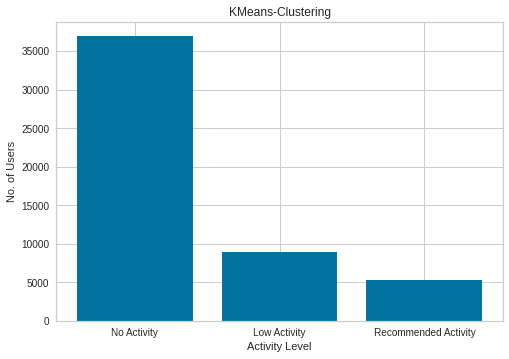

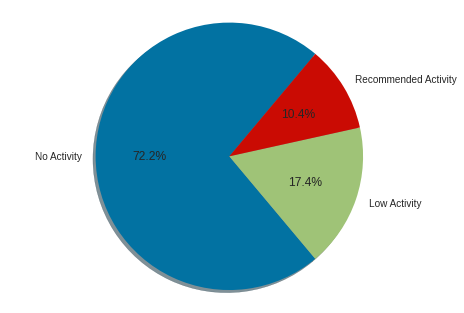

In [ ]:
showBinCounts(featMatrWitClust)

Silhouetter Score: 0.604


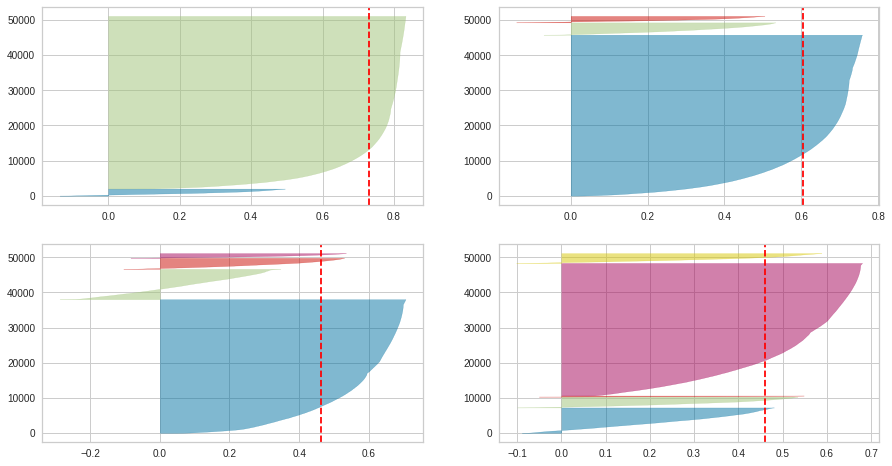

In [ ]:
silhouette(featureMatrix)

In [ ]:
onCampFeatMatrWitClust = getClusters(onCampFeatMatr, onCampMACs)

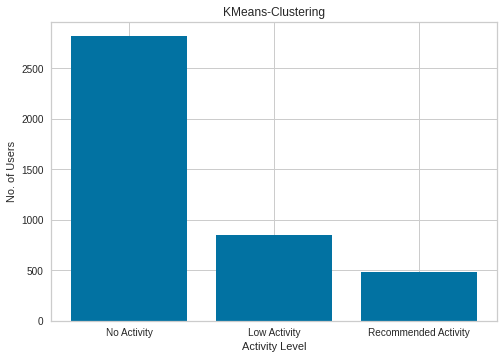

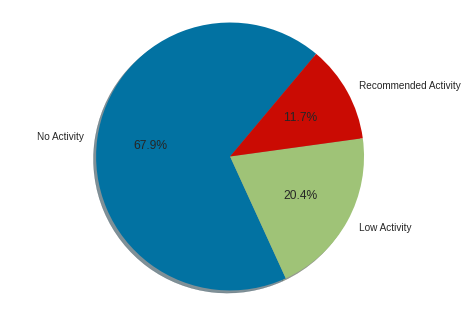

In [ ]:
showBinCounts(onCampFeatMatrWitClust)

Silhouetter Score: 0.617


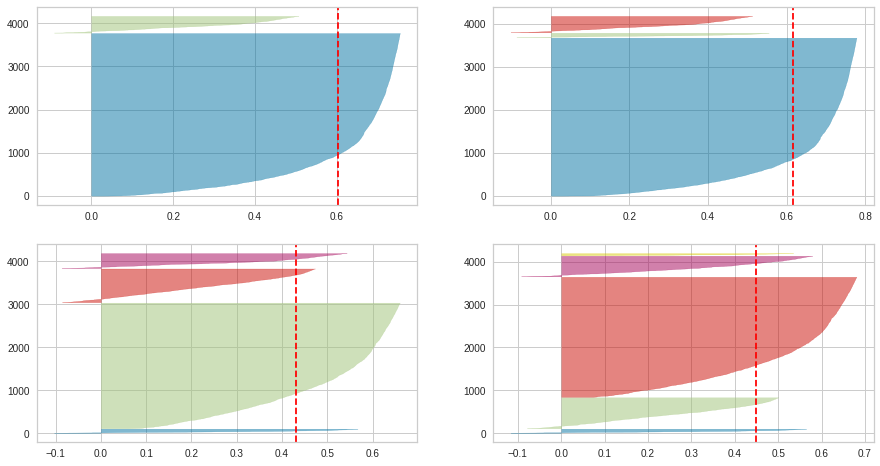

In [ ]:
silhouette(onCampFeatMatr)

# Activity Score Calculation and Graphical/Statistical Analysis

In [ ]:
def getEquiFreq(data):
  found = False
  x = len(data)
  y = len(data)
  for i, prob in enumerate(data):
    if prob < (2/3) and found == False:
      y = i
      found = True
    elif prob < (1/3):
      x = i
      break
  return [len(data) - x, len(data) - y]

In [ ]:
def graphHistAndCDF(featureMatrix):
  # exploring the data creating graphs, so far just have a cdf graph
  healthScores = (2 * featureMatrix[:,0]) + featureMatrix[:,1] + (2 * featureMatrix[:,2]) + (-0.1 * featureMatrix[:,3])
  pdf = {}
  for item in healthScores :
    pdf[item] = pdf.get(item, 0) + 1
  e = np.array(list(pdf.items()))
  e = e[np.argsort(e[:, 0])]
  x = e[:, 0]
  y = np.cumsum(e[:, 1])
  total = y[-1]
  y = y / total
  left = healthScores.min() - 0.1
  plt.hist(healthScores, density = True, bins = 300)
  plt.xlim(left = left, right = 8)
  plt.title('Health Score Histogram')
  plt.xlabel('Health Score')
  plt.ylabel('Proportion')
  plt.show()

  indices = getEquiFreq(np.flip(y))
  equiFreqs = [x[int(indices[0])], x[int(indices[1])]]

  plt.plot(x, y)
  plt.axvline(x = equiFreqs[0], color = "red")
  plt.axvline(x = equiFreqs[1], color = "red")
  plt.xlim(left = left, right = 8)
  plt.title('Health Score CDF')
  plt.xlabel('Health Score')
  plt.ylabel('Percentage <= Health Score')
  plt.show()

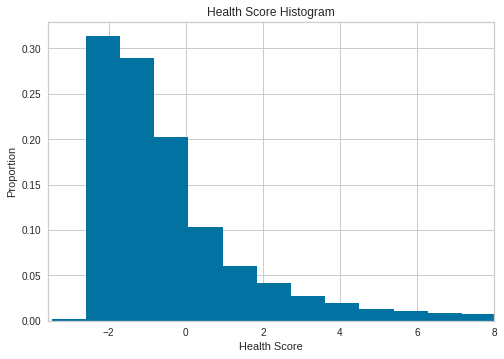

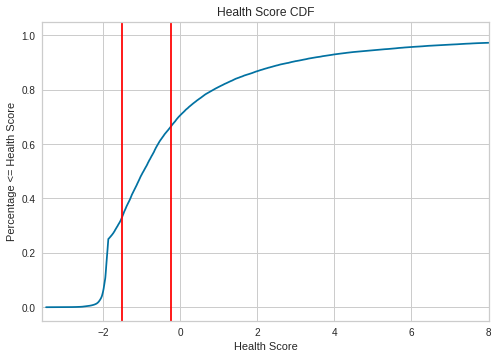

In [ ]:
standarFeatureMatrix = (featureMatrix-featureMatrix.mean()) / featureMatrix.std()
graphHistAndCDF(standarFeatureMatrix.to_numpy())

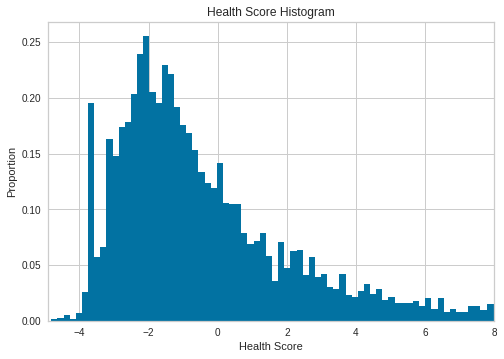

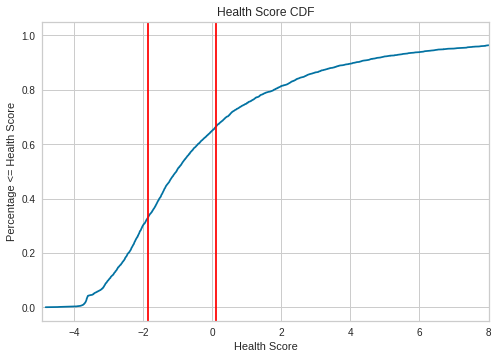

In [ ]:
onCampStandarFeatureMatrix = (onCampFeatMatr-onCampFeatMatr.mean()) / onCampFeatMatr.std()
graphHistAndCDF(onCampStandarFeatureMatrix.to_numpy())

# On-Campus Students Building Visitation

In [ ]:
# count the number of visitations to each building and add column
OnCampStudBuild = studentsMerged.value_counts(['name']).reset_index(name='c')

In [ ]:
# Top 5 Visited Buildings For On-Campus Students
plt.bar(OnCampStudBuild['name'].head(), OnCampStudBuild['c'].head())
plt.xticks(rotation=25)

In [ ]:
# Top 5 Least Visited Buildings For On-Campus Students
plt.bar(OnCampStudBuild['name'].tail(), OnCampStudBuild['c'].tail())
plt.xticks(rotation=25)